✅ Cell 1: Install Dependencies


In [ ]:
# Cell 1 (Optional): Install dependencies
# !pip install torch torchvision matplotlib numpy

✅ Cell 2: Imports & Device Setup


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

# Device selection: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


✅ Cell 3: Load MNIST and Define Noise Function

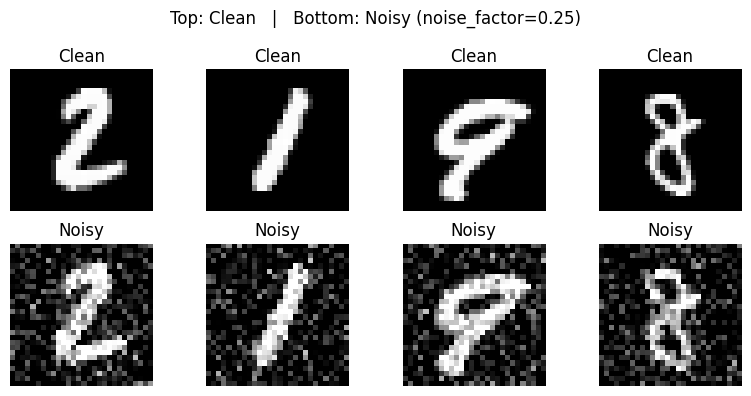

In [ ]:
# 3.1 Simple transform: just convert to tensor [0,1]
transform = transforms.ToTensor()

# 3.2 Download MNIST (train + test)
full_train = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

# 3.3 Carve out a small validation split (10% of training)
val_size = int(0.1 * len(full_train))
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

# 3.4 DataLoaders (batch_size = 128)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)


# 3.5 Gaussian-noise function (moderate noise_factor = 0.25)
def add_noise(imgs, noise_factor=0.3):
    """
    Adds Gaussian noise to a batch of MNIST images (shape B×1×28×28).
    - noise_factor=0.25 is a good compromise: not too heavy, not too light.
    """
    noisy = imgs + noise_factor * torch.randn_like(imgs)
    noisy = torch.clamp(noisy, 0.0, 1.0)
    return noisy

# 3.6 Quick look: show 4 clean vs. noisy examples
sample_imgs, _ = next(iter(train_loader))
sample_imgs = sample_imgs[:4].to(device)
noisy_sample = add_noise(sample_imgs, noise_factor=0.25)

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i in range(4):
    axes[0, i].imshow(sample_imgs[i][0].cpu(), cmap='gray')
    axes[0, i].set_title("Clean")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(noisy_sample[i][0].cpu(), cmap='gray')
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
plt.suptitle("Top: Clean   |   Bottom: Noisy (noise_factor=0.25)")
plt.tight_layout()
plt.show()


✅ Cell 4: Define a Lightweight Convolutional Autoencoder


In [3]:
# Cell 4: Define a Lightweight Convolutional Autoencoder

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder: 1×28×28 → 8×7×7
        self.encoder = nn.Sequential(
            # 1×28×28 → 16×14×14
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # 16×14×14 → 8×7×7
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
        )
        # Decoder: 8×7×7 → 1×28×28
        self.decoder = nn.Sequential(
            # 8×7×7 → 16×14×14
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # 16×14×14 → 1×28×28
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # ensure output ∈ [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = ConvAutoencoder().to(device)
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)


✅ Cell 5: Loss Function, Optimizer, and PSNR Metric


In [4]:
# Cell 5: Setup Loss + Optimizer + (Optional) PSNR Helper

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# (Optional) If you want to quantify PSNR on validation:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def batch_psnr(clean_imgs, recon_imgs):
    """
    Compute average PSNR over a batch of (clean, reconstructed) images.
    Each tensor must be in [0,1] with shape (B,1,28,28).
    """
    clean_np = clean_imgs.detach().cpu().numpy()
    recon_np = recon_imgs.detach().cpu().numpy()
    psnr_vals = []
    for i in range(clean_np.shape[0]):
        psnr_vals.append(compare_psnr(clean_np[i,0], recon_np[i,0], data_range=1.0))
    return float(np.mean(psnr_vals))

num_epochs = 20   # train a bit longer for better quality

train_losses = []
val_psnrs = []


✅ Cell 6: Training Loop


In [5]:
# Cell 6: Training Loop (Conv Autoencoder)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_factor=0.25).to(device)

        # Forward + Compute Loss
        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)

        # Backward + Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Evaluate PSNR on validation set (optional)
    model.eval()
    with torch.no_grad():
        psnr_accum = 0.0
        total = 0
        for v_imgs, _ in val_loader:
            v_imgs = v_imgs.to(device)
            v_noisy = add_noise(v_imgs, noise_factor=0.25).to(device)
            v_recon = model(v_noisy)
            psnr_accum += batch_psnr(v_imgs, v_recon) * v_imgs.size(0)
            total += v_imgs.size(0)
        avg_psnr = psnr_accum / total
        val_psnrs.append(avg_psnr)
    
    print(
        f"Epoch [{epoch+1:02d}/{num_epochs}]  "
        f"Train Loss: {epoch_loss:.6f}   "
        f"Val PSNR: {avg_psnr:.2f} dB"
    )

print("Training complete.")


Epoch [01/20]  Train Loss: 0.059026   Val PSNR: 20.62 dB
Epoch [02/20]  Train Loss: 0.006572   Val PSNR: 22.82 dB
Epoch [03/20]  Train Loss: 0.005170   Val PSNR: 23.33 dB
Epoch [04/20]  Train Loss: 0.004810   Val PSNR: 23.57 dB
Epoch [05/20]  Train Loss: 0.004644   Val PSNR: 23.65 dB
Epoch [06/20]  Train Loss: 0.004536   Val PSNR: 23.72 dB
Epoch [07/20]  Train Loss: 0.004462   Val PSNR: 23.80 dB
Epoch [08/20]  Train Loss: 0.004408   Val PSNR: 23.79 dB
Epoch [09/20]  Train Loss: 0.004371   Val PSNR: 23.91 dB
Epoch [10/20]  Train Loss: 0.004336   Val PSNR: 23.93 dB
Epoch [11/20]  Train Loss: 0.004315   Val PSNR: 23.92 dB
Epoch [12/20]  Train Loss: 0.004286   Val PSNR: 24.00 dB
Epoch [13/20]  Train Loss: 0.004272   Val PSNR: 24.01 dB
Epoch [14/20]  Train Loss: 0.004254   Val PSNR: 23.92 dB
Epoch [15/20]  Train Loss: 0.004234   Val PSNR: 24.03 dB
Epoch [16/20]  Train Loss: 0.004223   Val PSNR: 24.02 dB
Epoch [17/20]  Train Loss: 0.004212   Val PSNR: 24.04 dB
Epoch [18/20]  Train Loss: 0.00

✅ Cell 7: Plot Training Loss & Validation PSNR


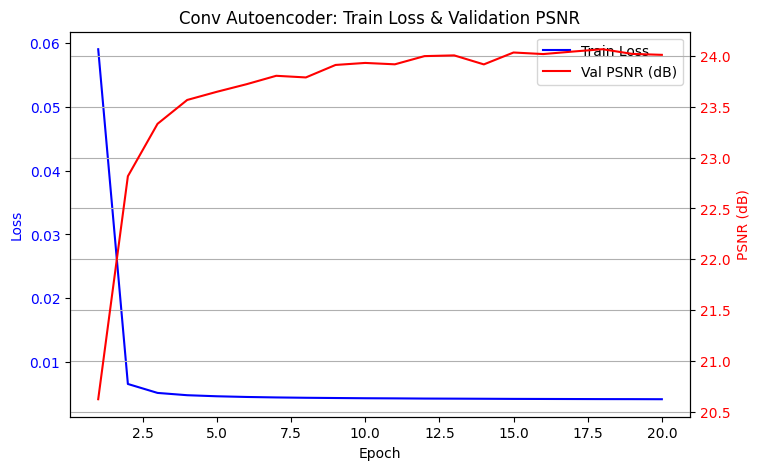

In [6]:
# Cell 7: Plot Training Loss & Validation PSNR

epochs_range = np.arange(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

ax1.plot(epochs_range, train_losses, 'b-', label="Train Loss")
ax2.plot(epochs_range, val_psnrs,  'r-', label="Val PSNR (dB)")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='b')
ax2.set_ylabel("PSNR (dB)", color='r')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_title("Conv Autoencoder: Train Loss & Validation PSNR")

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.grid(True)
plt.show()


✅ Cell 8: Test Set Visualization


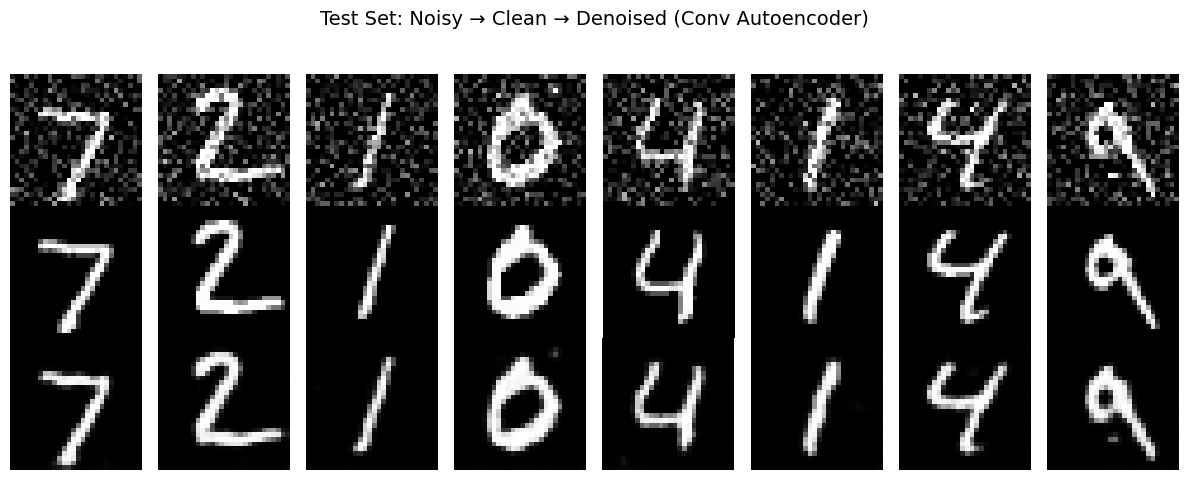

In [7]:
# Cell 8: Visualize on Test Set (Sharper Denoised Digits)

model.eval()
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
    test_imgs = test_imgs.to(device)

    # Add the same noise factor = 0.25
    noisy_test = add_noise(test_imgs, noise_factor=0.25).to(device)
    recon_test = model(noisy_test)

    # Show first N examples
    N = 8
    fig, axes = plt.subplots(3, N, figsize=(12, 5))
    for i in range(N):
        # Row 1: Noisy
        axes[0, i].imshow(noisy_test[i][0].cpu(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel("Noisy", fontsize=12)

        # Row 2: Clean (ground truth)
        axes[1, i].imshow(test_imgs[i][0].cpu(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel("Clean", fontsize=12)

        # Row 3: Denoised (Conv Autoencoder)
        axes[2, i].imshow(recon_test[i][0].cpu(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_ylabel("Denoised", fontsize=12)

    plt.suptitle("Test Set: Noisy → Clean → Denoised (Conv Autoencoder)", fontsize=14)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()
